## **Assignment 1: Sentiment Analysis**


In [1]:
!pip install -q -U watermark
!pip install -qq transformers

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.26.0

numpy       : 1.19.5
pandas      : 1.2.5
torch       : 1.7.1+cu110
transformers: 4.5.1



In [3]:
#Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'


RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

2021-10-03 21:39:30.779508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
   

GPU is available


In [5]:
'''Collab Content'''
# from google.colab import drive
# drive.mount('gdrive')

'Collab Content'

### **1. Importing the data**

In [6]:
df_train = pd.read_csv('../input/imdb-dataset-hw/Train.csv')
df_test = pd.read_csv('../input/imdb-dataset-hw/Test.csv')
df_valid = pd.read_csv('../input/imdb-dataset-hw/Valid.csv')

In [7]:
df_train.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
print(df_train.label.dtype)

int64


In [9]:
df_train.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
df_test.label.value_counts()

1    2505
0    2495
Name: label, dtype: int64

### **2. Text Preprocessing**

In [11]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize(x):
    temp = ""
    for i in range(len(x.split())):
        lem = lemmatizer.lemmatize(x.split()[i], pos="v")
        temp += lem + " "
    temp = temp.rstrip()
    return temp


In [12]:
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text 
def clean_func(text):
    text = strip_tags(text)
    text = strip_punctuation(text)
    text = strip_multiple_whitespaces(text)
    text = remove_stopwords(text)
    text = strip_short(text, minsize=2)
    text = text.lower()
    text = lemmatize(text)
    return text

In [13]:
df_train.loc[:, 'text'] = df_train['text'].progress_apply(clean_func)
df_test.loc[:, 'text'] = df_test['text'].progress_apply(clean_func)
df_valid.loc[:, 'text'] = df_valid['text'].progress_apply(clean_func)

#Collab_Content
# x_train,y_train = train_data['text'].values,train_data['label'].values
# x_test,y_test = test_data['text'].values,test_data['label'].values
# x_valid, y_valid = test_data['text'].values,test_data['label'].values

100%|██████████| 5000/5000 [00:10<00:00, 469.02it/s]


### **3. Exploratory Data Analysis**

In [14]:
df_test['text'][0],df_test['label'][0]

('write series complete stink fest jim belushi involve heavily but day tragic happenstance occur after white sox game end realize remote way room now get walk room remote tv turn channel but walk country watch tv state nut say so decide hang tight couch fate store what fate store episode episode remember little broad general sweep blanket judgment base zero objective experiential evidence whatsoever opinions completely right this total crud pie belushi comedic delivery hairy lighthouse foghorn the women physically attractive stepford elicit real feel viewer there absolutely reason stop run local tv station gasoline flamethrower send copy mutt howl hell except except wonderful comic sty lings larry joe campbell america greatest comic character actor this guy play belushi brother law andy gold how good well aside funny job belushi look good that like try butt warts look good but campbell pull style someone invent nobel prize comic buffoonery win year without larry joe consist slightly va

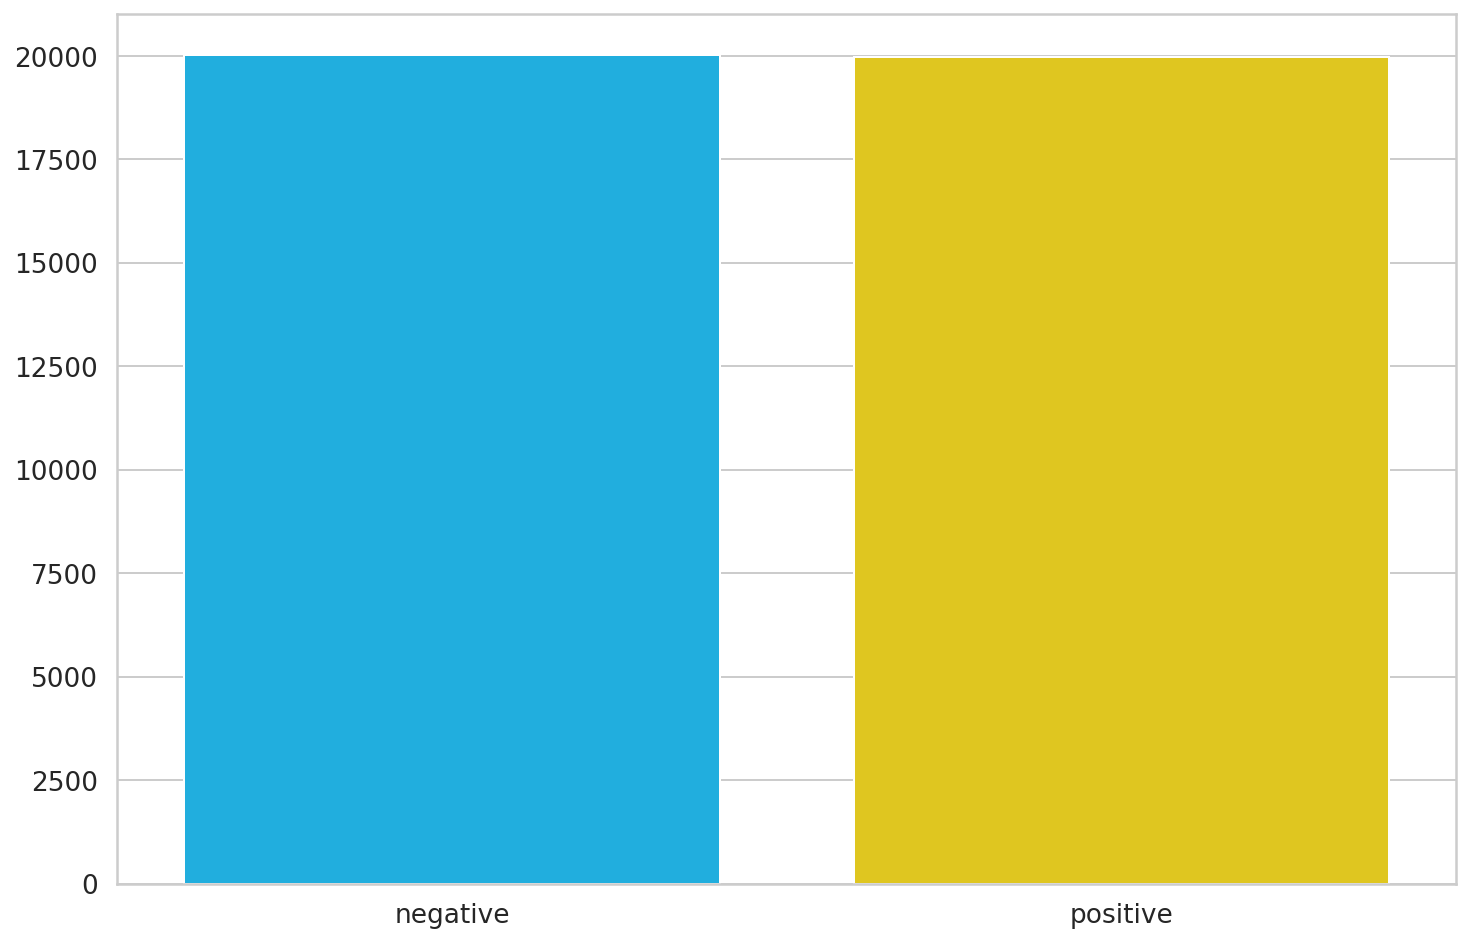

In [15]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
label_plot = pd.Series(df_train['label']).value_counts()
x2=np.array(['negative','positive'])
sns.barplot(x=np.array(['negative','positive']),y=label_plot.values)
plt.show()

(19981, 2)


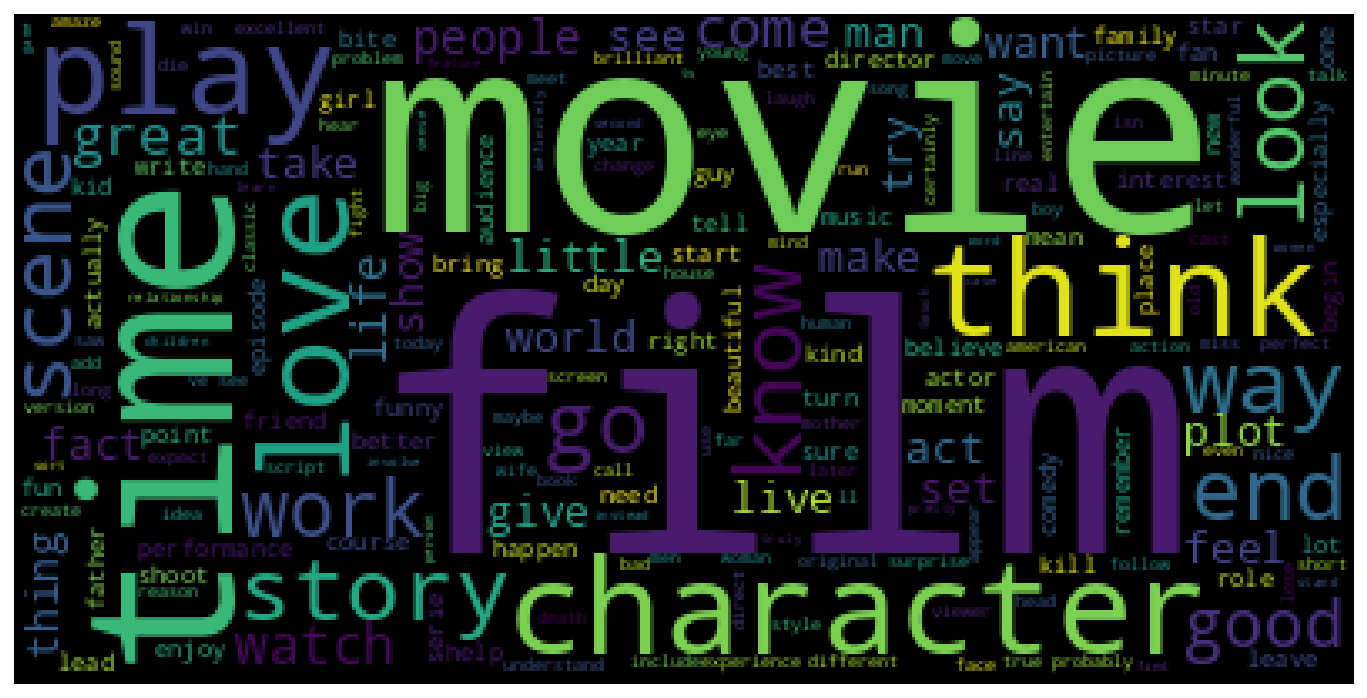

In [16]:
from wordcloud import WordCloud, STOPWORDS
df_train_1 = df_train[df_train['label'] ==1] 
print(df_train_1.shape)
wordcloud = WordCloud().generate(' '.join(df_train_1['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

(20019, 2)


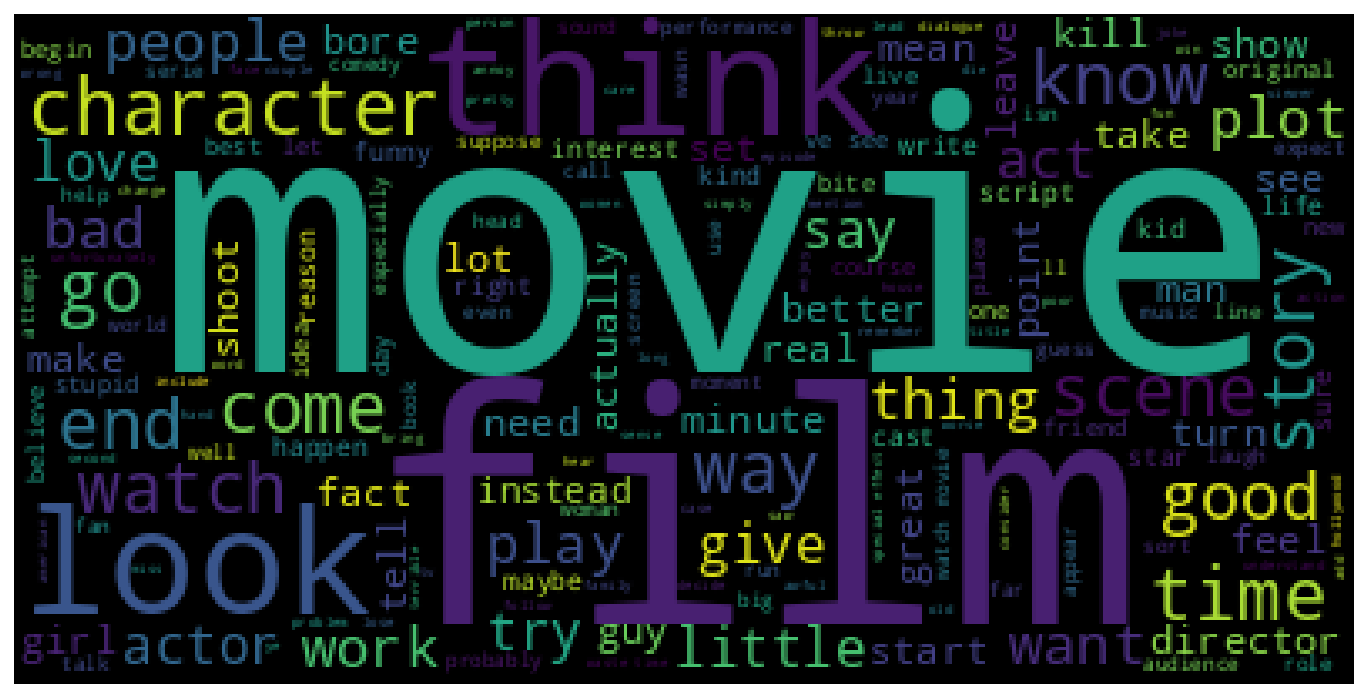

In [17]:
df_train_0 = df_train[df_train['label'] ==0] 
print(df_train_0.shape)
wordcloud = WordCloud().generate(' '.join(df_train_0['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### **4. Tokenization**
#### BERT Tokenizer
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the bert tokenizer vocabulary.

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
'''Transformation function'''
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(sample_txt)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


When was I last outside? I am stuck at home for 2 weeks.


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])


Applying the tokenizer to one sentence just to see the output tokens






In [20]:
#Tokenization_Example
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


Special Tokens (Tokens at start and end of each sentence, Padding Token, Unknown Token)

In [21]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [22]:
# token_lens = []

# for txt in df_train.text:
#     tokens = tokenizer.encode(txt, max_length=512,truncation=True)
#     token_lens.append(len(tokens))

In [23]:
# sns.distplot(token_lens)
# plt.xlim([0, 1000]);
# plt.xlabel('Token count');

In [24]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [25]:
df_train.shape, df_valid.shape, df_test.shape

((40000, 2), (5000, 2), (5000, 2))

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
MAX_LEN = 150
BATCH_SIZE = 16

### **5. Creating a batch generator**

Creating an Data  for our IMDB dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [28]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape) 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [30]:
#print(data['review_text'])

In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
model_test = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [33]:
 last_hidden_state=model_test['last_hidden_state']
 pooled_output=model_test['pooler_output']
 print(last_hidden_state.shape)
 print(bert_model.config.hidden_size)
 print(pooled_output.shape)

torch.Size([1, 32, 768])
768
torch.Size([1, 768])


In [34]:
# class SentimentClassifier(nn.Module):

#   def __init__(self, n_classes):
#     super(SentimentClassifier, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.drop = nn.Dropout(p=0.3)
#     self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
#   def forward(self, input_ids, attention_mask):
#     _, pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     output = self.drop(pooled_output)
#     return self.out(output)

### **6. Defining Custom Classificater Class**

##### -> Fine tuning pre-trained bert
##### -> Regularization with dropout probability 0.25
##### -> n_classes = 2

In [35]:
class SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
     self.drop = nn.Dropout(p=0.25)                                 
     self.out = nn.Linear(self.bert.config.hidden_size, n_classes) 
  
   def forward(self, input_ids, attention_mask):
     returned = self.bert(
       input_ids=input_ids,
       attention_mask=attention_mask
     )
     pooled_output = returned["pooler_output"]
     output = self.drop(pooled_output)
     return self.out(output)

In [36]:
model = SentimentClassifier(2)
model = model.to(device)

In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [38]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3048, 0.6952],
        [0.3100, 0.6900],
        [0.2219, 0.7781],
        [0.2540, 0.7460],
        [0.3139, 0.6861],
        [0.3949, 0.6051],
        [0.3090, 0.6910],
        [0.4365, 0.5635],
        [0.4222, 0.5778],
        [0.4008, 0.5992],
        [0.3082, 0.6918],
        [0.3500, 0.6500],
        [0.2750, 0.7250],
        [0.3568, 0.6432],
        [0.3492, 0.6508],
        [0.3940, 0.6060]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [39]:
EPOCHS = 8
learning_rate = 2e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


### **7. Model Training**

train_task, eval_task functions in preparation to train the model.

-> clip the gradients to avoid exploding gradients.

In [40]:
# View optimizers that you could choose from

In [41]:
def train_task(
   model, 
   data_loader, 
   loss_fn, 
   optimizer, 
   device, 
   scheduler, 
   n_examples
 ):
   model = model.train()
   losses = []
   correct_predictions = 0
   for d in data_loader:
     input_ids = d["input_ids"].to(device)
     attention_mask = d["attention_mask"].to(device)
     targets = d["targets"].to(device)
     outputs = model(
       input_ids=input_ids,
       attention_mask=attention_mask
     )
     max_prob, preds = torch.max(outputs, dim=1)    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
     loss = loss_fn(outputs, targets)
     correct_predictions += torch.sum(preds == targets)
     losses.append(loss.item())
     loss.backward()     
     nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
     optimizer.step()
     scheduler.step()
     optimizer.zero_grad()
   return correct_predictions.double() / n_examples, np.mean(losses)     # Return the mean loss and the ratio of correct predictions. 


In [42]:
def eval_task(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)
        
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

This defines a trained model optimized with the Adam optimizer, all the while tracking the accuracy using val_acc metric. We also track Loss on the validation set and track variables for monitoring progress


In [43]:
 history = defaultdict(list)          
 best_accuracy = 0                    
 for epoch in range(EPOCHS):
   print(f'Epoch {epoch + 1}/{EPOCHS}')
   train_acc, train_loss = train_task(
     model,
     train_data_loader,    
     loss_fn, 
     optimizer, 
     device, 
     scheduler, 
     len(df_train)
   )
   print(f'Train loss {train_loss} accuracy {train_acc}')
   val_acc, val_loss = eval_task(
     model,
     val_data_loader,
     loss_fn, 
     device, 
     len(df_valid)
   )
   print(f'Val   loss {val_loss} accuracy {val_acc}')
   history['train_acc'].append(train_acc)
   history['train_loss'].append(train_loss)
   history['val_acc'].append(val_acc)
   history['val_loss'].append(val_loss)
   if val_acc > best_accuracy:
     torch.save(model.state_dict(), 'best_model_state_dict.pth')
     best_accuracy = val_acc

Epoch 1/8
Train loss 0.46184448503553865 accuracy 0.797625
Val   loss 0.3920545827704497 accuracy 0.8518
Epoch 2/8
Train loss 0.3454883549891412 accuracy 0.872
Val   loss 0.3358965750557546 accuracy 0.866
Epoch 3/8
Train loss 0.29002166023552417 accuracy 0.895475
Val   loss 0.3082994843919437 accuracy 0.8764000000000001
Epoch 4/8
Train loss 0.2534257645267993 accuracy 0.9168000000000001
Val   loss 0.357514533794488 accuracy 0.8812000000000001
Epoch 5/8
Train loss 0.22742256539892405 accuracy 0.93305
Val   loss 0.42456479513416656 accuracy 0.8792000000000001
Epoch 6/8
Train loss 0.2083029576715082 accuracy 0.944725
Val   loss 0.4274790089089459 accuracy 0.8772000000000001
Epoch 7/8
Train loss 0.19155926978271454 accuracy 0.9528500000000001
Val   loss 0.43226904981135844 accuracy 0.883
Epoch 8/8
Train loss 0.17519114357437937 accuracy 0.95755
Val   loss 0.5074051142708895 accuracy 0.881


(0.0, 1.0)

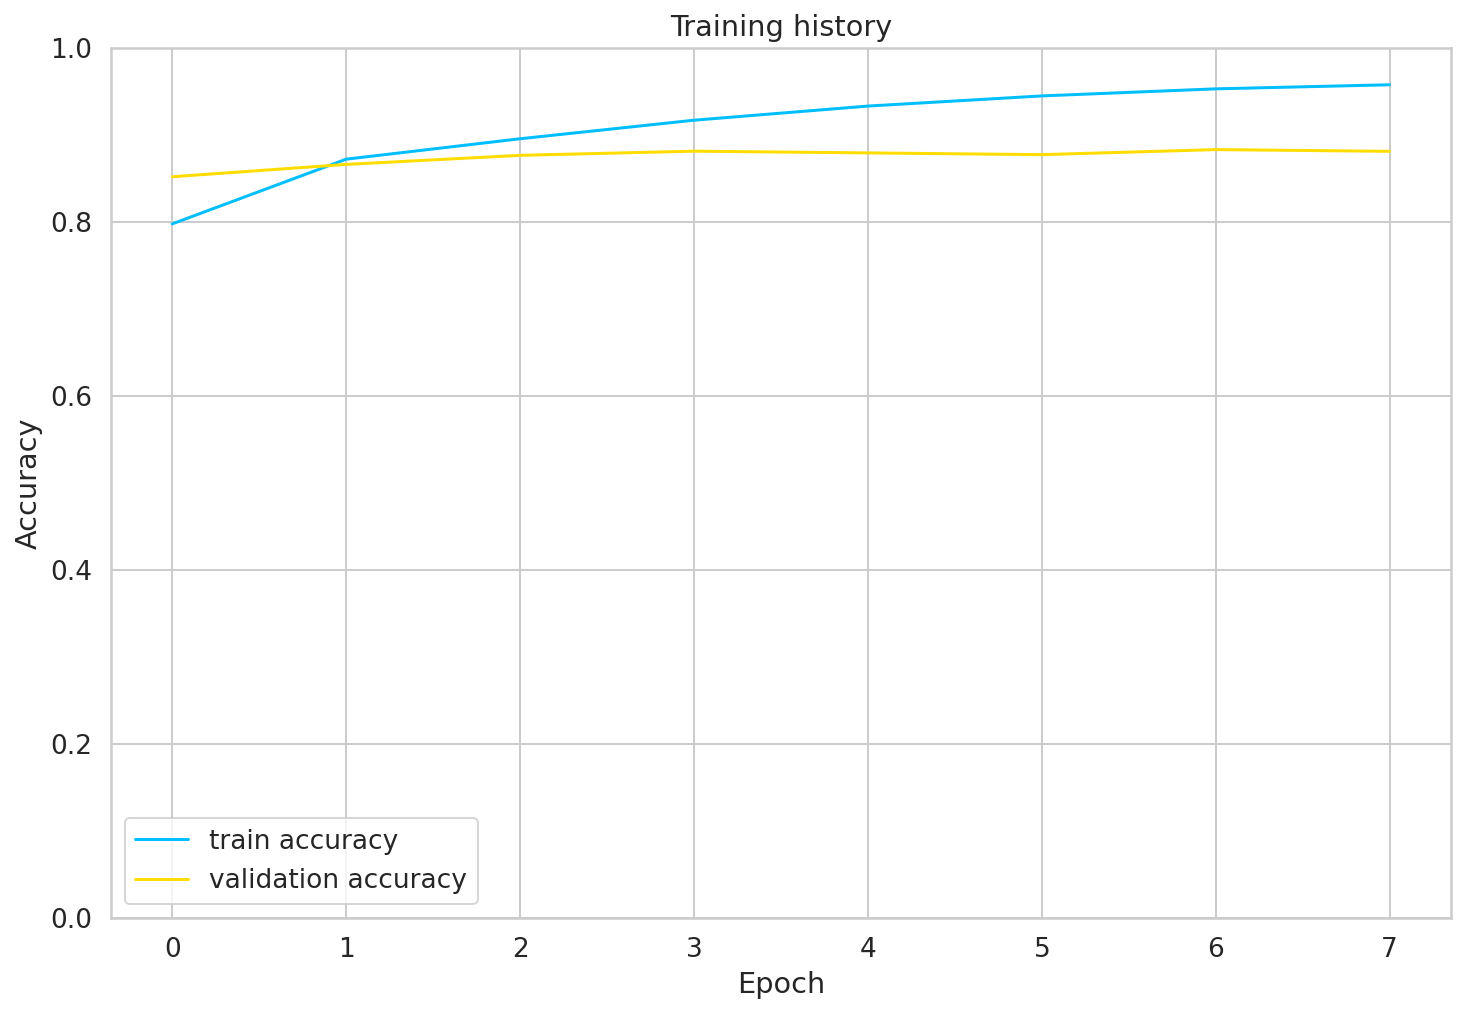

In [44]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [45]:
test_acc, _ = eval_task(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.8814000000000001

### **8. Making a prediction**


In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [47]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [48]:
# def load_model(model: nn.Module, path: Path) -> Tuple:
#     state = torch.load(str(path))
#     model.load_state_dict(state['model'])
#     print('Loaded model from epoch {epoch}'.format(**state))
#     return state, state['best_valid_loss']

### **9. Accuracy Report**


In [49]:
target_names = ['class_0','class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.90      0.86      0.88      2495
     class_1       0.86      0.90      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### **10. Confusion Matrix**


In [50]:
matrix = confusion_matrix(y_test,y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[2267  238]
 [ 355 2140]]


<AxesSubplot:>

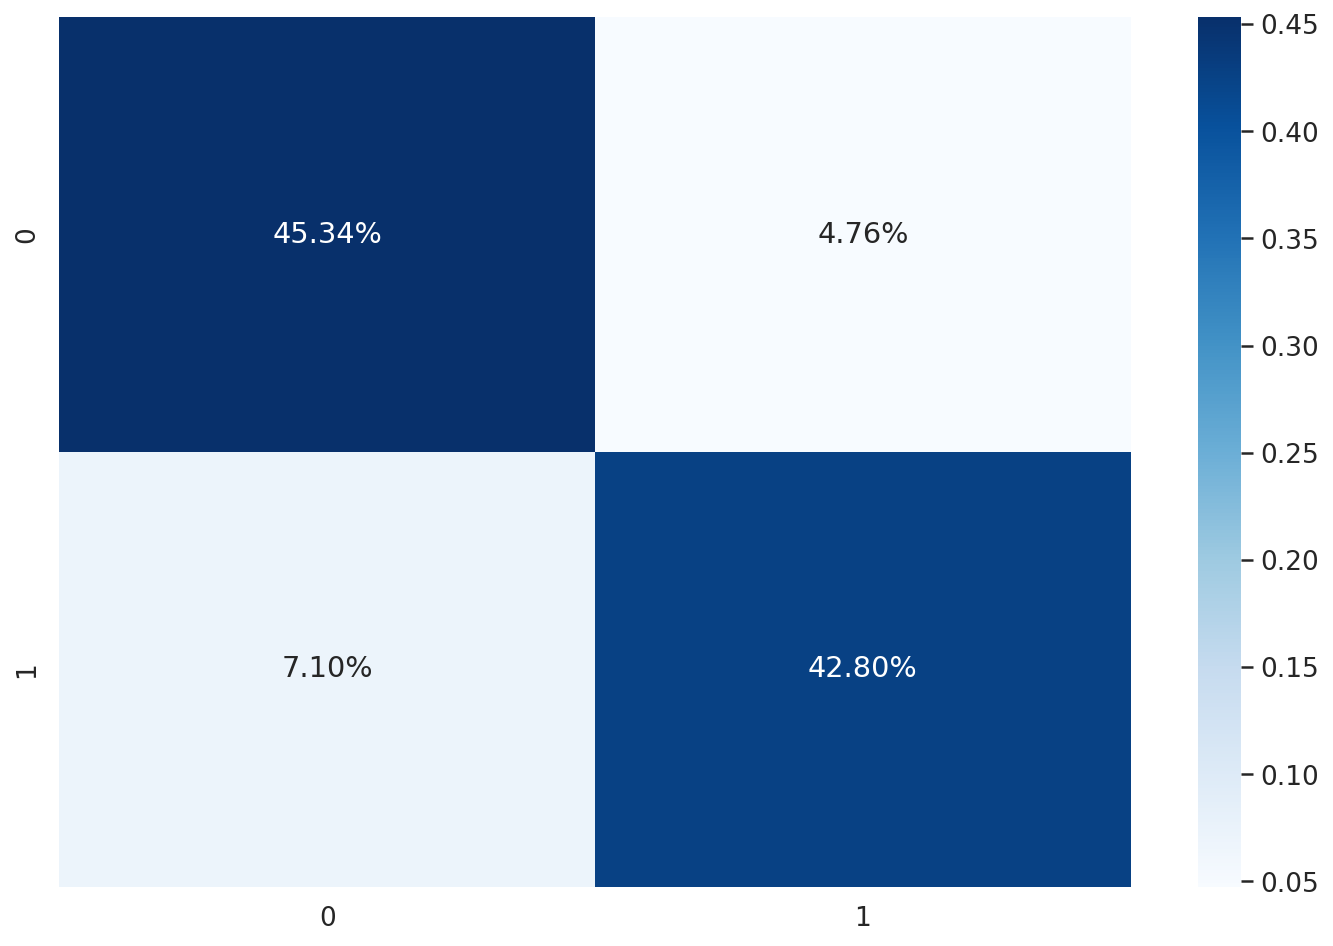

In [51]:
import seaborn as sns
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')


### ----------End-------

In [52]:
print(model.parameters)

<bound method Module.parameters of SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((